# ch 12 과학적 계산

## 12.1 유한 차분법 (Finite Difference Method)
: 연속된 공간에서 격자를 정의하여 연속적인 공간을 이산 공간으로 변환하여 근사 해를 구하는 방법
- 각 점의 변화를 계산할 때 주변 값을 이용한다.
- 합성곱 신경망의 필터 계산과 같은 방법을 취한다.

![스크린샷 2024-02-03 오전 6.21.51.png](../img/스크린샷%202024-02-03%20오전%206.21.51.png)

$\phi$는 이미지의 값, $n$은 시간 스텝, $\Delta t$ 시간의 변화량, $\epsilon^2$은 계수를 나타낸다.
$conv(\Phi^n)$은 라플라스 연산으로 3X3 미분 필터로 표현된다.

![스크린샷 2024-02-03 오전 6.22.00.png](../img/스크린샷%202024-02-03%20오전%206.22.00.png)


In [1]:
# 라이브러리

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# 초깃값 설정하기

def initial_value(nx, ny): # 이미지 사이즈 nx, ny를 정한다.
    h = 1/nx
    x = np.linspace(-0.5*h,h*(nx+0.5),nx) # 격자 수 정의
    y = np.linspace(-0.5*h,h*(ny+0.5),ny)
    pn = 0.5 * (2 * np.random.rand(nx,ny)-1)
    plt.figure(figsize=(4,4))
    plt.imshow(pn,interpolation='nearest',cmap='jet',extent=[x.min(),x.max(),y.min(),y.max()], origin='lower', aspect='auto')
    plt.title('$u(x,y,t=0)$',fontsize=20)
    plt.clim(-1,1)
    plt.show() 
    return x, y, pn

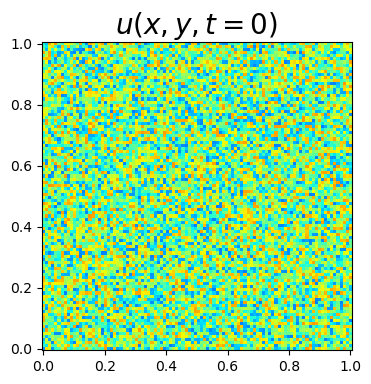

In [3]:
nx=ny=100
h=1/nx
h2=h**2
dt =.1*h**2
eps = 10*h/(2*np.sqrt(2)*np.arctanh(0.9))
maxiter = 301
maxtime = dt*maxiter
x,y,pn = initial_value(nx,ny)

In [4]:
# 유한차분법 구현하기

class FDM(nn.Module):
    def __init__(self,h2,dt,eps,device):
        super(FDM,self).__init__()
        self.delta = torch.Tensor([[[[0.,1.,0.],[1.,-4.,1],[0.,1.,0.]]]]).to(device) # 2차 미분 필터 , F.con2d의 필터는 3차원으로 만들어야함
        self.pad = nn.ReplicationPad2d(1) # 1겹 패딩
        self.alpha = dt/eps*2
        self.beta = dt/h2
    
    def forward(self,x):
        u_pad = self.pad(x) # 경계조건을 고려하기 위해 패딩을 씌운다.
        diffusion = F.conv2d(u_pad,self.delta)  # 합성곱 연산을 미리 정의된 self.delta 필터를 사용하고 입력값은 u_pad다.
        x = (1+self.alpha)*x- self.alpha*x**3+ self.beta*diffusion
        return x 

In [5]:
# 유한 차분법 클래스 선언하기
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = FDM(h2, dt, eps, device).to(device)
img = torch.FloatTensor(pn).view(-1,1,nx,ny).to(device) # 초기 이미지를 모델에 넣기 위해 4차원 텐서로 변환

In [6]:
# 유한 차분법 시행하기
solutions = []
with torch.no_grad():
    for step in range(maxiter):
        u = model(img)
        img = u # phi^(n+1) <- f(phi^n) : 이전 스텝의 이미지를 이용하여 다음 스텝의 이미지를 구현한다.
        solutions.append(img.view(nx,ny).cpu().numpy()) # 모든 결과 이미지를 넘파이 배열로 저장한다.

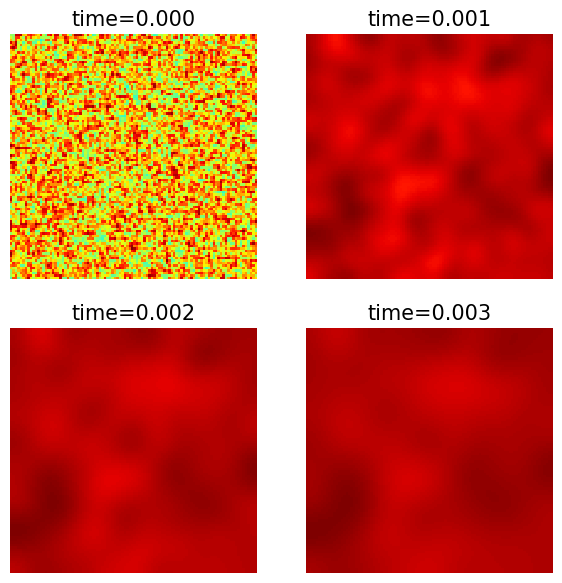

In [7]:
# 결과 확인하기
fig = plt.figure(figsize=(7,7))
d = range(221,225) # 2행2열 형태의 그래프를 그릴 수 있도록 값을 지정
timeslot = np.linspace(0,len(solutions)-1,4) # 0초부터 마지막까지 4등분한 시간을 계산한다.
for i, subp in enumerate(d): # 부분 그래프를 하나씩 만들어 전체를 출력
    plt.subplot(subp)
    plt.imshow(solutions[int(timeslot[i])], interpolation = 'nearest', cmap = 'jet', extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', aspect='auto')
    plt.clim(-1)
    plt.axis('off')
    plt.title('time=%.3f' % (dt*timeslot[i]),fontsize=15)
plt.show()

## 12.2 은닉 유체 메카니즘 (Hidden Fluid Mechanics, HFM)